# Understanding personal protective behaviours and opportunities for interventions:
## Results from a multi-method investigation of cross-sectional data
#### Kaisa Sauro, James Twose, Gjalt-Jorn Peters, Matti Heino & Nelli Hankonen

## approach used here: _CatBoost Regression_

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, RepeatedStratifiedKFold, RepeatedKFold

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

In [4]:
from sklearn.model_selection import KFold

In [5]:
import pingouin as pg

In [6]:
from catboost import CatBoostRegressor, Pool

In [7]:
# import xgboost
import shap
shap.initjs()

In [8]:
_ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [9]:
session_info.show(req_file_name="corona_preppers-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [10]:
df = pd.read_csv("data/shield_gjames_21-09-20_prepped.csv").drop("Unnamed: 0", axis=1)

In [11]:
df.head()

id  sampling_weight  demographic_gender demographic_age  \
0   1         2.060959                   2             60+   
1   2         1.784139                   2           40-49   
2   3         1.204000                   1             60+   
3   4         2.232220                   1             60+   
4   5         1.627940                   2           18-29   

   demographic_4_areas  demographic_8_areas  demographic_higher_education  \
0                    2                    7                             0   
1                    1                    1                             1   
2                    1                    2                             1   
3                    2                    6                             0   
4                    1                    3                             0   

   behaviour_indoors_nonhouseholders  behaviour_close_contact  \
0                                  2                        5   
1                                  3                        3   
2                                  4                        4   
3                                  4                        3   
4                                  6                        3   

   behaviour_quarantined  ...  intention_public_transport_recoded  \
0                      2  ...                                   0   
1                      2  ...                                   0   
2                      2  ...                                   0   
3                      2  ...                                   0   
4                      2  ...                                   0   

   intention_indoor_meeting_recoded  intention_restaurant_recoded  \
0                                 0                             0   
1                                 1                             1   
2                                 0                             0   
3                                 2                             0   
4                                 2                             0   

   intention_pa_recoded  intention_composite  \
0                     0                    0   
1                     1                    3   
2                     0                    0   
3                     2                    4   
4                     0                    2   

   behaviour_indoors_nonhouseholders_recoded  behaviour_unmasked_recoded  \
0                                   1.000000                    0.000000   
1                                   0.785714                    0.214286   
2                                   0.500000                    0.214286   
3                                   0.500000                    0.500000   
4                                   0.000000                    0.214286   

   behavior_composite  behavior_composite_recoded  \
0            0.000000                    0.000000   
1            0.168367                    0.841837   
2            0.107143                    0.535714   
3            0.250000                    1.250000   
4            0.000000                    0.000000   

   intention_behavior_composite  
0                      0.000000  
1                      1.920918  
2                      0.267857  
3                      2.625000  
4                      1.000000  

[5 rows x 106 columns]

In [12]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [13]:
drop_sdt = True
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [14]:
df.shape

(2272, 87)

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [15]:
target = "intention_behavior_composite"

In [16]:
df[target] = (df[target] - 10) * -1

In [17]:
features_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective").columns.tolist()

In [18]:
meta_df = pd.read_excel("metadata/questionLabels.xlsx").iloc[:, 0:7]

In [19]:
meta_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective|^behaviour|^intention").columns.tolist()

In [20]:
pd.set_option("display.max_colwidth", 350)
pd.set_option('display.expand_frame_repr', True)
meta_df.loc[meta_df["New variable name"].isin(meta_list), ["Item english translation", "New variable name"]]

Item english translation  \
12                                         How often in the last 7 days have you been indoors with people outside your household so that it is not related to obligations? For example, meeting friends, visiting hobbies, non-essential shopping, or other activities that are not required for your work or other duties.   
13                                                                           In the last 7 days, have you been in close contact with people outside your household? Direct contact means spending more than one minute less than two meters away from another person or touching (e.g., shaking hands) outdoors or indoors.   
14                                                                                                               Are you currently in quarantine or isolation due to an official instruction or order? (For example, because you are waiting for a corona test, have returned from abroad or been exposed to a coronavirus)   
15                                                                                                                                                                                                          How often in the last 7 days were you in your free time without a mask indoors with people you don’t live with?   
24                                                                                                                                                If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Grocery store or other store   
25                                                                                                                               If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Bus, train or other means of public transport   
26                                                                                                                               If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Meeting people outside your household indoors   
27                                                                                                                                             If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Cafe, restaurant or bar indoors   
28                                                                                                                                                             If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Indoor exercise   
29                                                                         Taking a mask with you to a store or public transport, for example, has already become automatic for some and is done without thinking. For others, taking a mask with them is not automatic at all, but requires conscious thinking and effort.   
30                                                                               Putting on a mask, for example in a shop or on public transport, has already become automatic for some and it happens without thinking. For others, putting on a mask is not automatic at all, but requires conscious thinking and effort.   
32                                                                                                                                                                                                            What consequences do you think it has if you use a face mask in your free time? If or when I use a face mask…   
33                                                                                                                                              

In [21]:
pd.set_option("display.max_colwidth", 100)

## EDA on the target
Check the amount of samples in the target

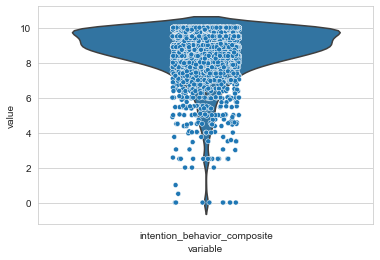

In [22]:
_ = sns.violinplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value"
               )
_ = sns.stripplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value",
                  edgecolor='white',
                  linewidth=0.5
               )

In [23]:
pd.crosstab(df["demographic_gender"], df["demographic_age"])

demographic_age     18-29  30-39  40-49  50-59  60+
demographic_gender                                 
1                     114    169    187    168  337
2                     281    185    229    211  391

In [24]:
target_df = df[target]
target_df.describe().to_frame().T

count      mean       std  min       25%  \
intention_behavior_composite  2272.0  8.582428  1.524704 -0.0  8.017857   

                                   50%  75%   max  
intention_behavior_composite  8.964286  9.5  10.0

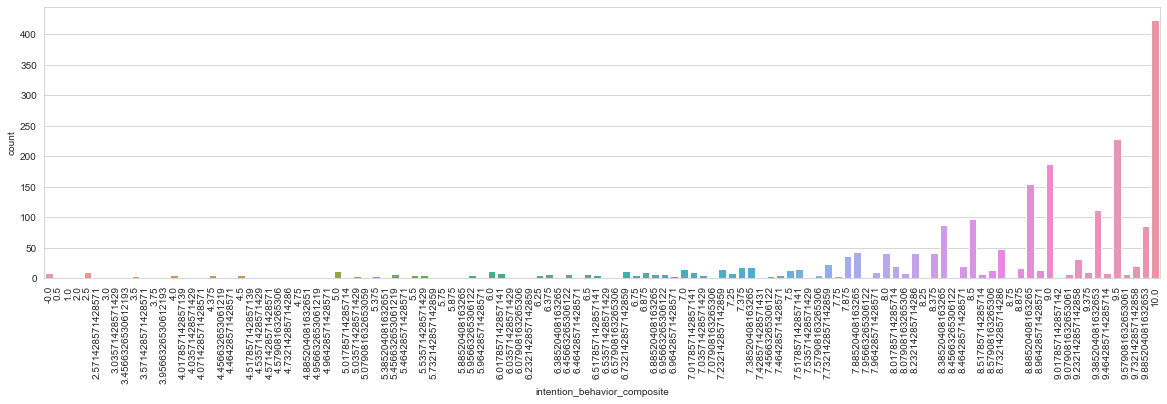

In [25]:
_ = plt.figure(figsize=(20, 5))
_ = sns.countplot(x=target_df)
_ = plt.xticks(rotation=90)

## Force all feature variables to categorical data

In [26]:
df[features_list] = df[features_list].astype("category")

In [27]:
df = (df[["demographic_age", "demographic_higher_education"] + features_list + [target]])

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   demographic_age                   2272 non-null   object  
 1   demographic_higher_education      2272 non-null   int64   
 2   automaticity_carry_mask           2272 non-null   category
 3   automaticity_put_on_mask          2272 non-null   category
 4   inst_attitude_protects_self       2272 non-null   category
 5   inst_attitude_protects_others     2272 non-null   category
 6   inst_attitude_sense_of_community  2272 non-null   category
 7   inst_attitude_enough_oxygen       2272 non-null   category
 8   inst_attitude_no_needless_waste   2272 non-null   category
 9   norms_family_friends              2272 non-null   category
 10  norms_risk_groups                 2272 non-null   category
 11  norms_officials                   2272 non-null   catego

In [29]:
grouping_var = target

In [30]:
display(df[grouping_var].value_counts().head().to_frame()), df.shape[0], df[grouping_var].value_counts().head().sum()

intention_behavior_composite
10.000000                           424
9.500000                            228
9.000000                            187
8.885204                            155
9.385204                            112

(None, 2272, 1106)

In [31]:
def naive_catboost_forest_summary(df: pd.DataFrame,
                                 grouping_var: str,
                                 column_list: list,
                                  plot_title: str
                                 ):
    y = df[grouping_var]
    X = df[column_list]

    feature_plot, ax = plt.subplots(figsize=(10,7))
    _ = sns.boxplot(ax=ax, 
                    data=X.apply(lambda x: x.cat.codes), 
                    orient="v", 
                   )
    _ = plt.title(f'Feature Distributions {plot_title}')
    _ = plt.setp(ax.get_xticklabels(), rotation=90)
    _ = plt.grid()
    _ = plt.tight_layout()
    _ = plt.show()

    model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

    # train the model
    _ = model.fit(X, y, cat_features=column_list)

    # create dataframe with importances per feature
    feature_importance = pd.Series(dict(zip(column_list, model.feature_importances_.round(2)))) 

    feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

    _ = plt.figure(figsize=(7, 7))
    gini_plot = sns.barplot(data=feature_importance_df, 
                            x="feature_importance", 
                            y="feature")
    _ = plt.title(f'Feature Importance {plot_title}')
    _ = plt.show()

    shap_values = model.get_feature_importance(Pool(X, label=y,cat_features=X.columns.tolist()), type="ShapValues")

    shap_values = shap_values[:,:-1]

    _ = shap.summary_plot(shap_values, 
                                  X.astype(int), 
                                  feature_names=X.columns, 
                                  max_display=X.shape[1],
                                 show=False,
                         title=plot_title) 
    shap_plot = plt.gca()
    
    tmp_actual = (X
     .melt(value_name='actual_value')
    )

    tmp_shap = (pd.DataFrame(shap_values, columns=column_list)
     .melt(value_name='shap_value')
    )

    shap_actual_df = pd.concat([tmp_actual, tmp_shap[["shap_value"]]], axis=1)

    
    y_pred = model.predict(X)

    df_test = pd.DataFrame({"y_pred": y_pred, grouping_var: y})

    user_ids_first = df_test.head(1).index.tolist()[0]
    user_ids_last = df_test.tail(1).index.tolist()[0]

    _ = plt.figure(figsize=(30,8))
    _ = plt.title(f"Catboost Regressor(fitted set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),4)} | bias Error = {round(np.mean(df_test['y_pred'] - df_test[grouping_var]), 4)} | {plot_title}")
    rmse_plot = plt.stem(df_test.index, df_test['y_pred'] - df_test[grouping_var], use_line_collection=True, linefmt='grey', markerfmt='D')
    _ = plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='+ RMSE', 
                   xmin = user_ids_first, 
                   xmax = user_ids_last
                  ) 
    _ = plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='- RMSE', 
                   xmin = user_ids_first, 
                   xmax = user_ids_last
                  ) 
    _ = plt.xticks(rotation=90, ticks=df_test.index)
    _ = plt.ylabel(f"'Error = y_predicted - {grouping_var}'")
    _ = plt.legend()
    _ = plt.show()
    
    return feature_plot, gini_plot.get_figure(), shap_plot.get_figure(), rmse_plot, feature_importance_df, shap_actual_df

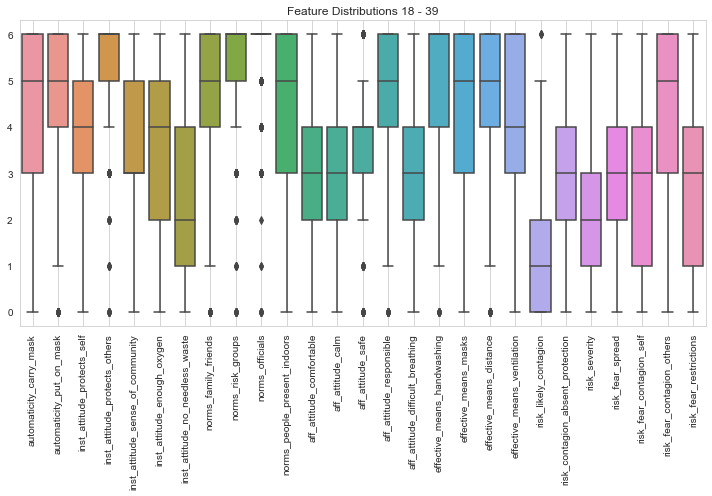

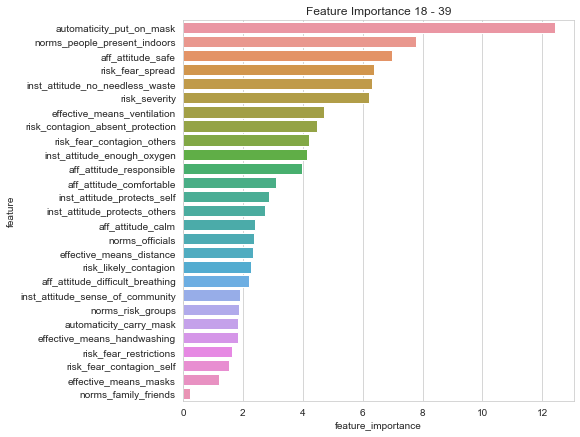

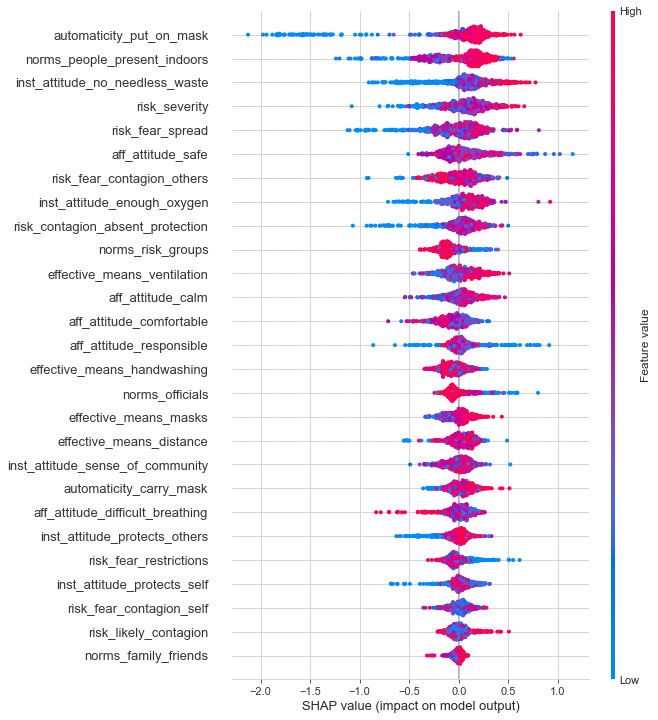

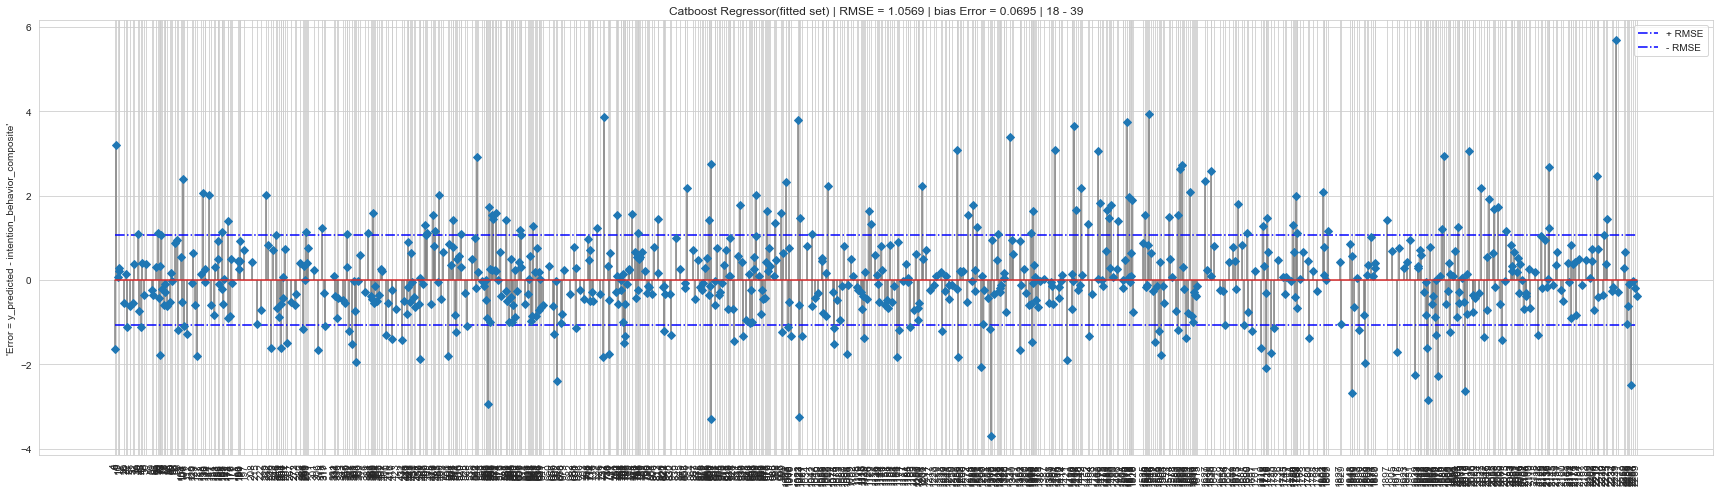

In [32]:
# %%capture
feature_plot_0, gini_plot_0, shap_plot_0, rmse_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="18 - 39"
                                                                                  )

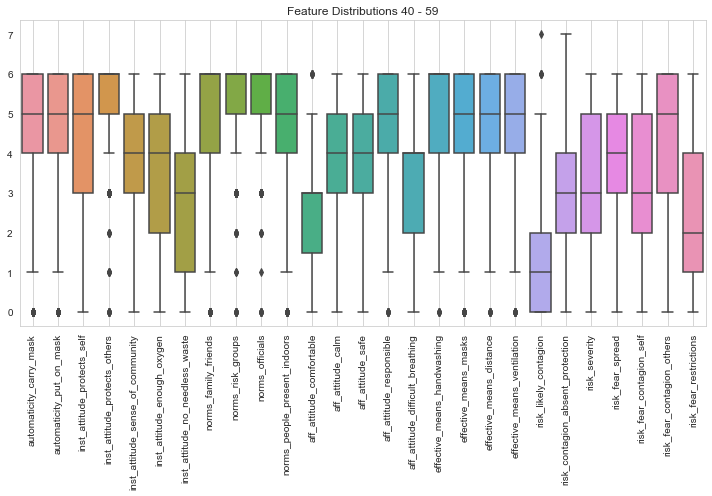

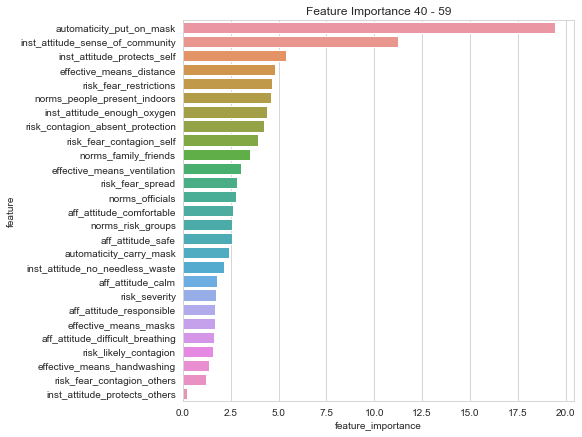

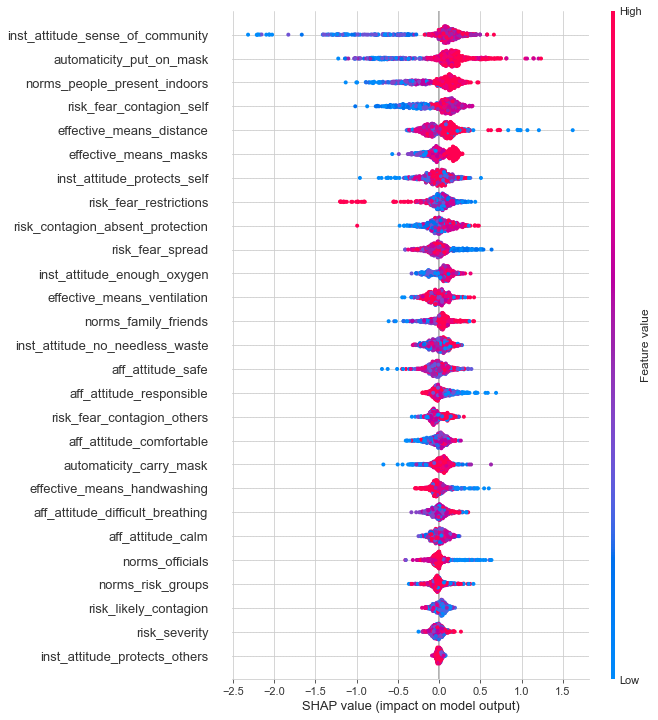

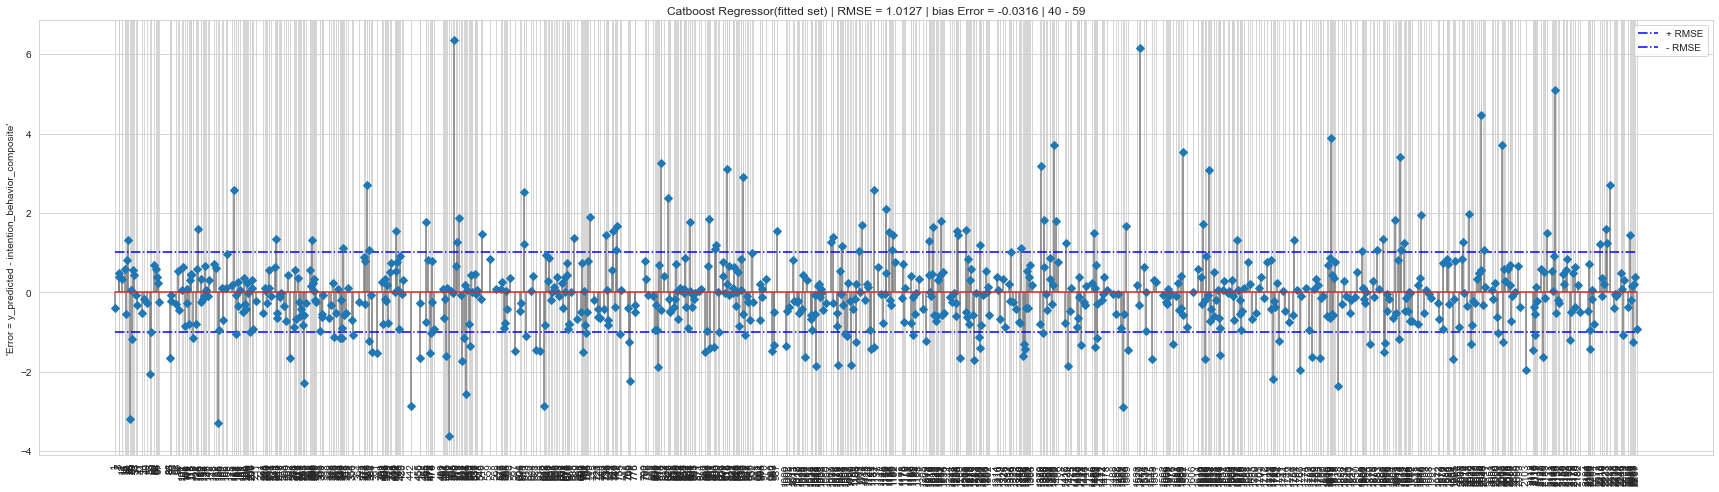

In [33]:
feature_plot_1, gini_plot_1, shap_plot_1, rmse_plot_1, feature_importance_df_1, shap_values_1 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['40-49', '50-59'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="40 - 59"
                                                                                  )

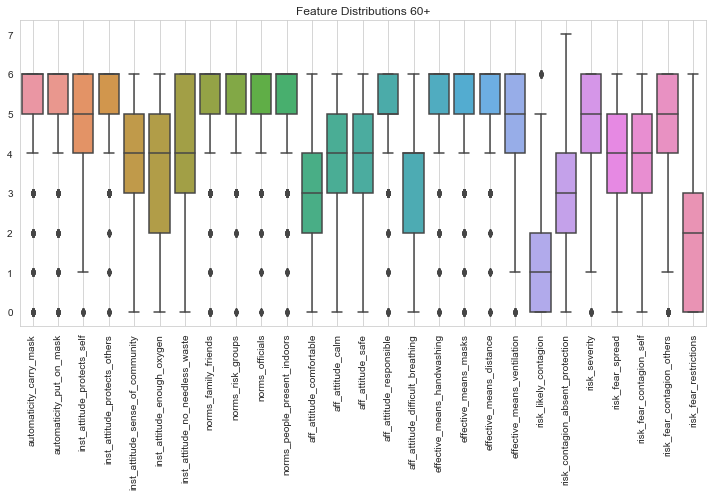

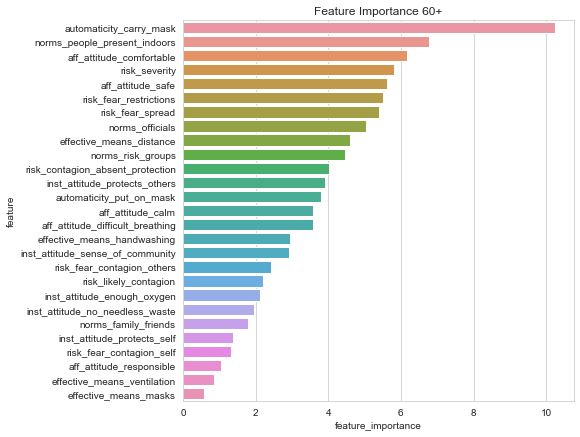

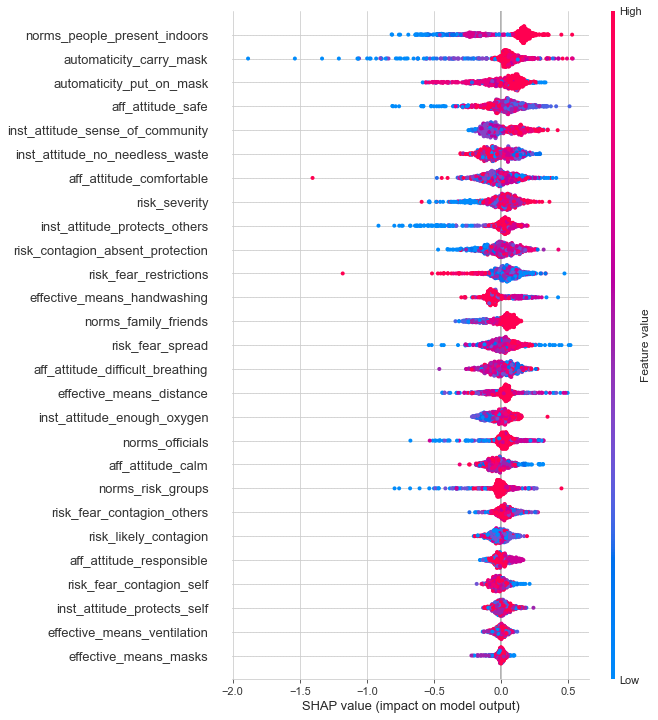

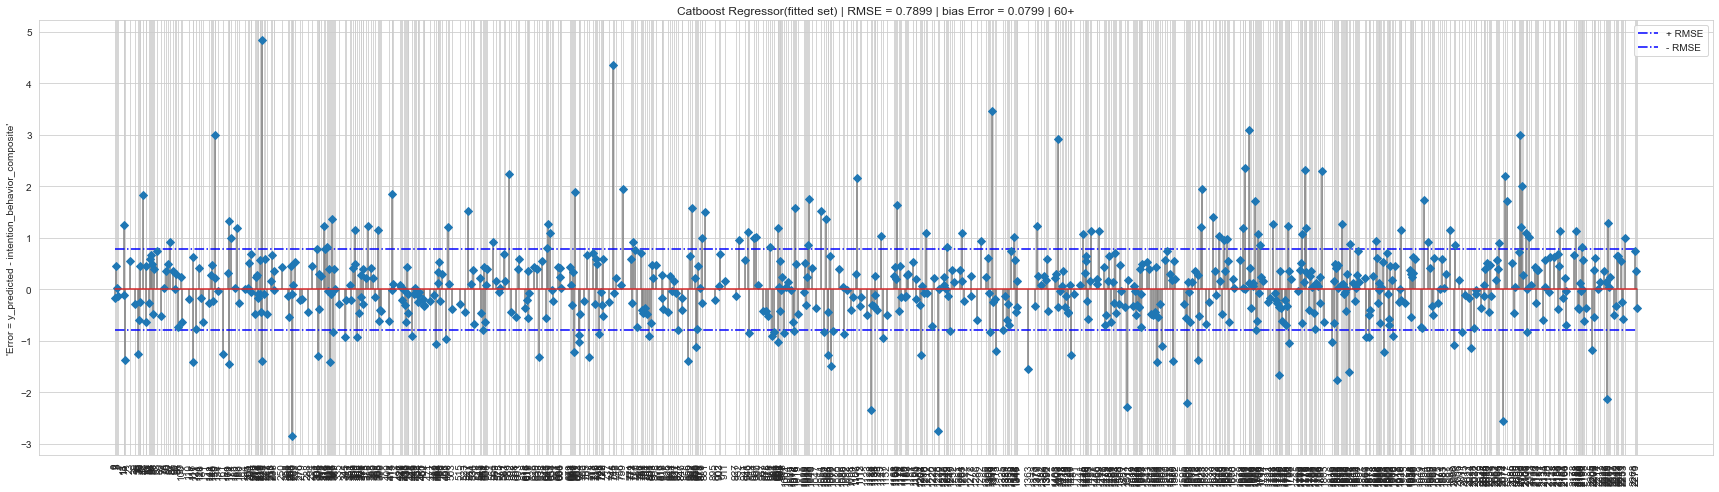

In [34]:
feature_plot_2, gini_plot_2, shap_plot_2, rmse_plot_2, feature_importance_df_2, shap_values_2 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['60+'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="60+"
                                                                                  )

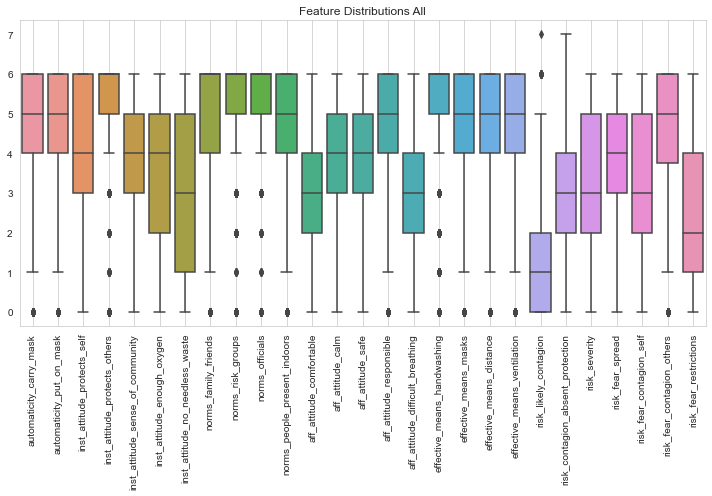

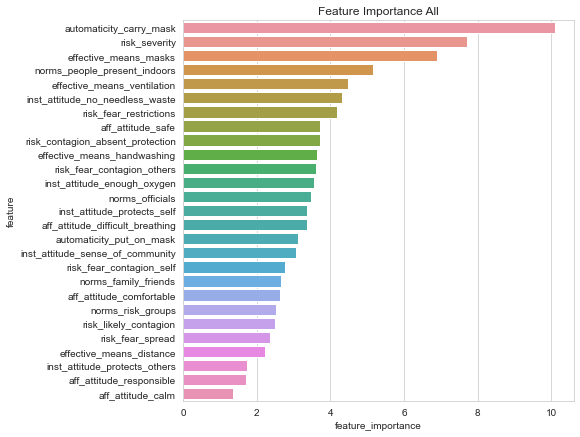

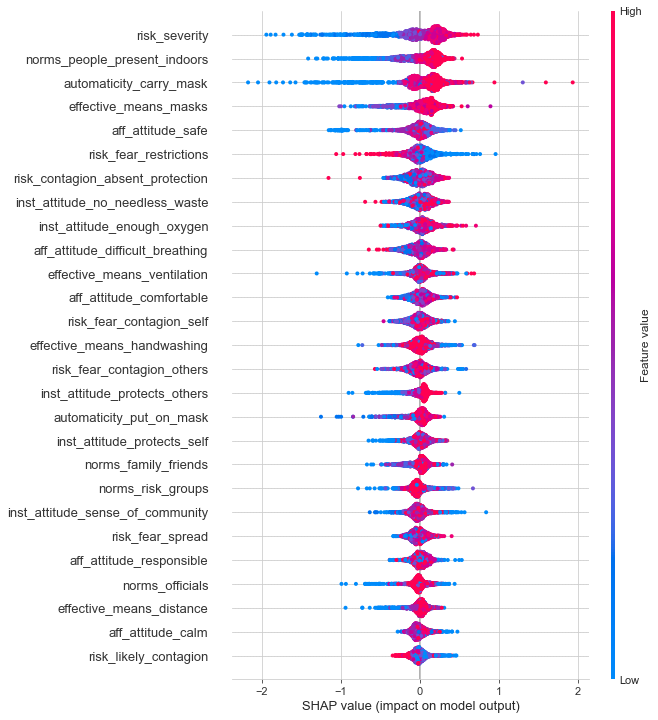

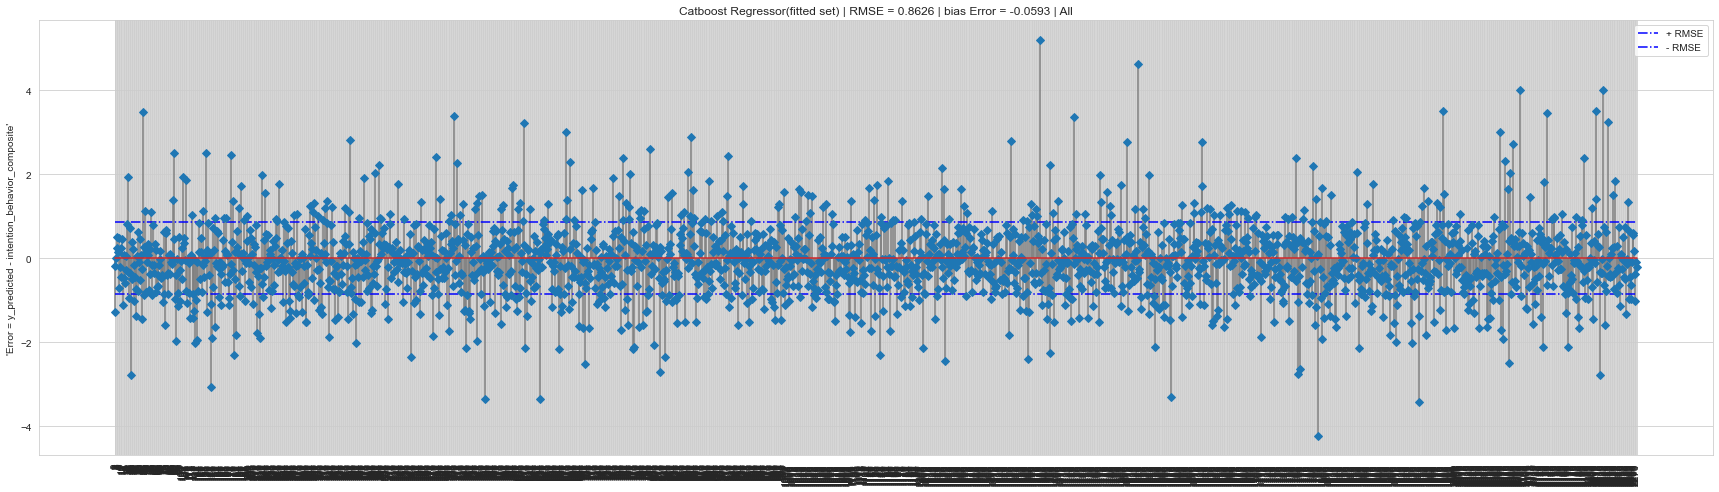

In [35]:
feature_plot_3, gini_plot_3, shap_plot_3, rmse_plot_3, feature_importance_df_3, shap_values_3 = naive_catboost_forest_summary(df = df,
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="All"
                                                                                  )

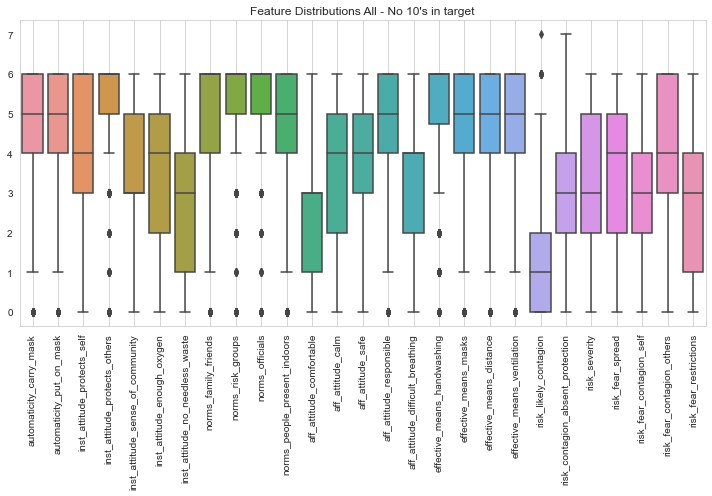

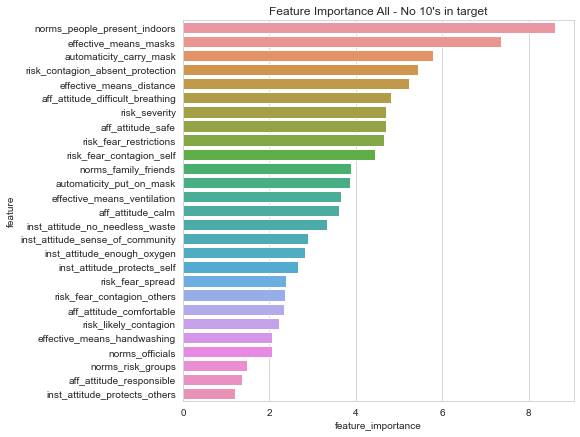

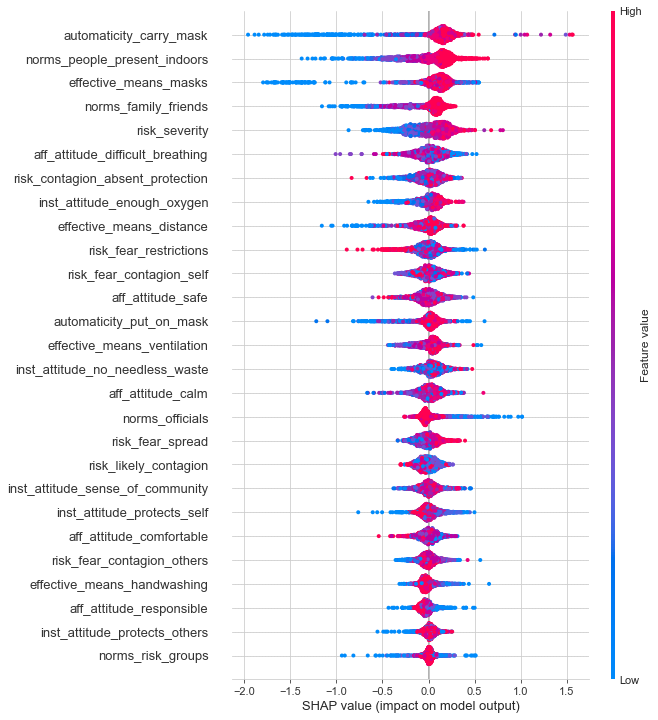

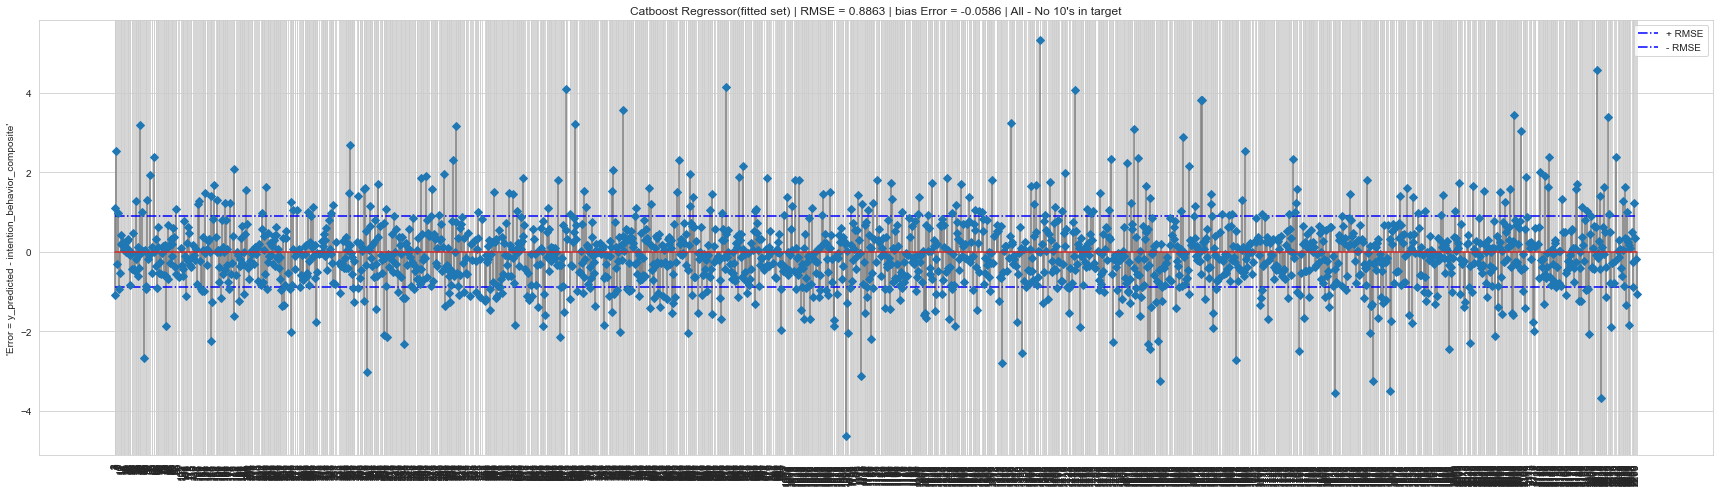

In [36]:
feature_plot_4, gini_plot_4, shap_plot_4, rmse_plot_4, feature_importance_df_4, shap_values_4 = naive_catboost_forest_summary(df = df[df[grouping_var]!=10],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="All - No 10's in target"
                                                                                  )

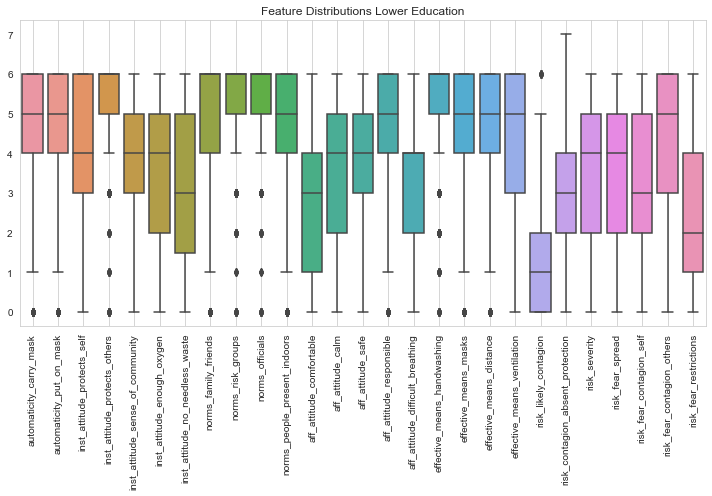

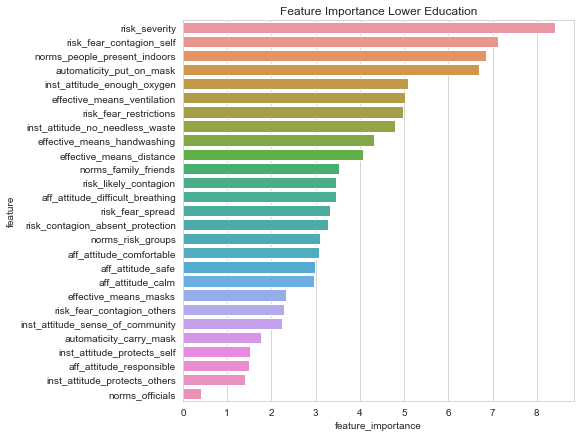

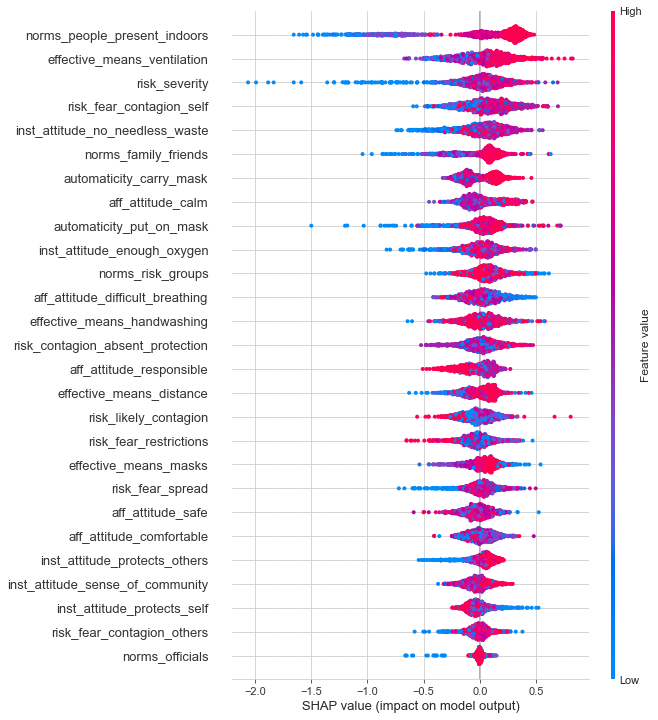

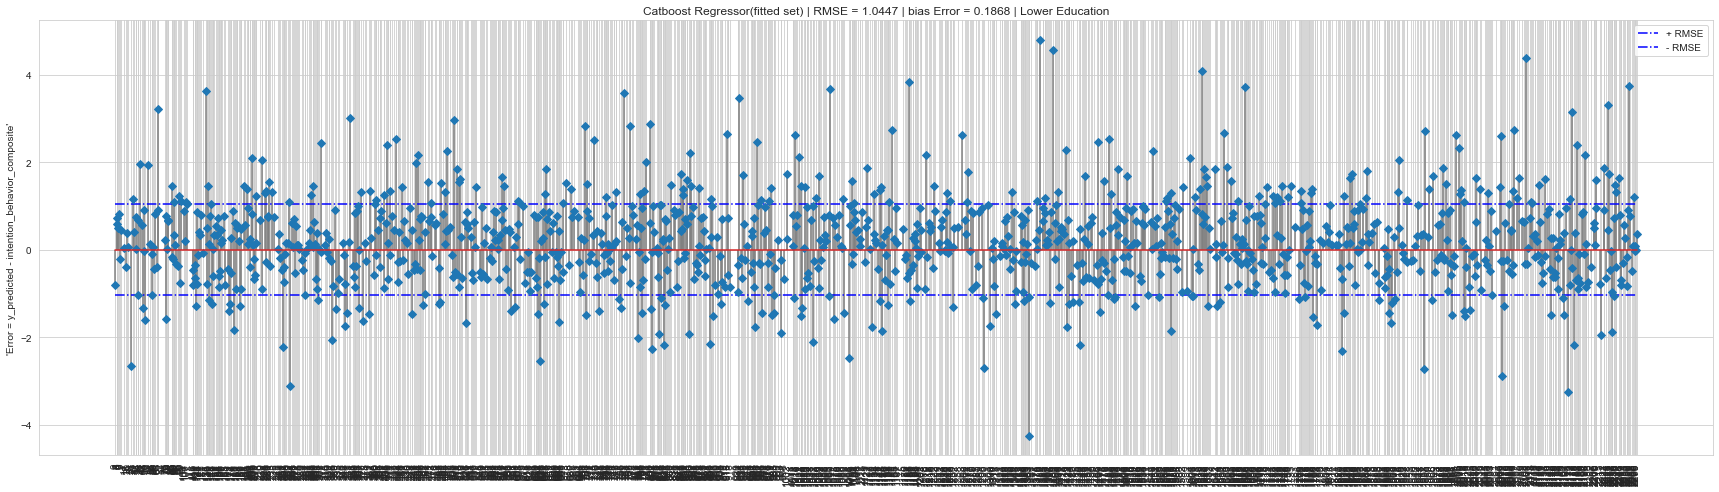

In [37]:
feature_plot_5, gini_plot_5, shap_plot_5, rmse_plot_5, feature_importance_df_5, shap_values_5 = naive_catboost_forest_summary(df = df[df["demographic_higher_education"]==0],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="Lower Education"
                                                                                  )

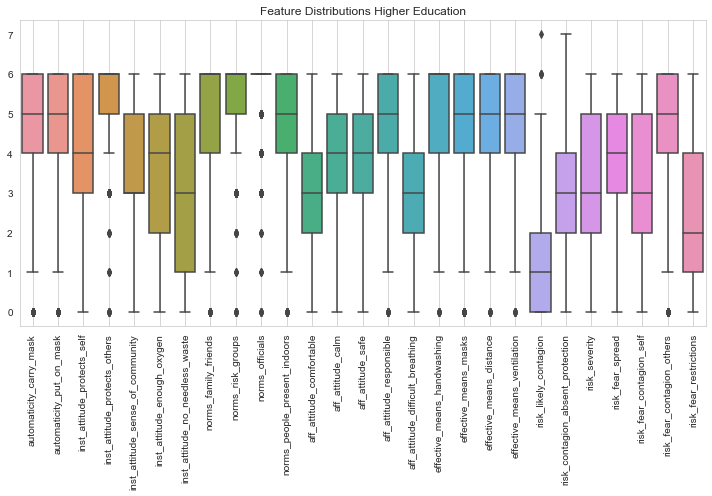

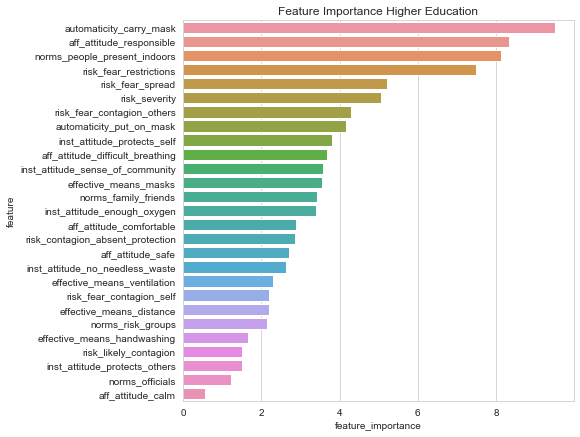

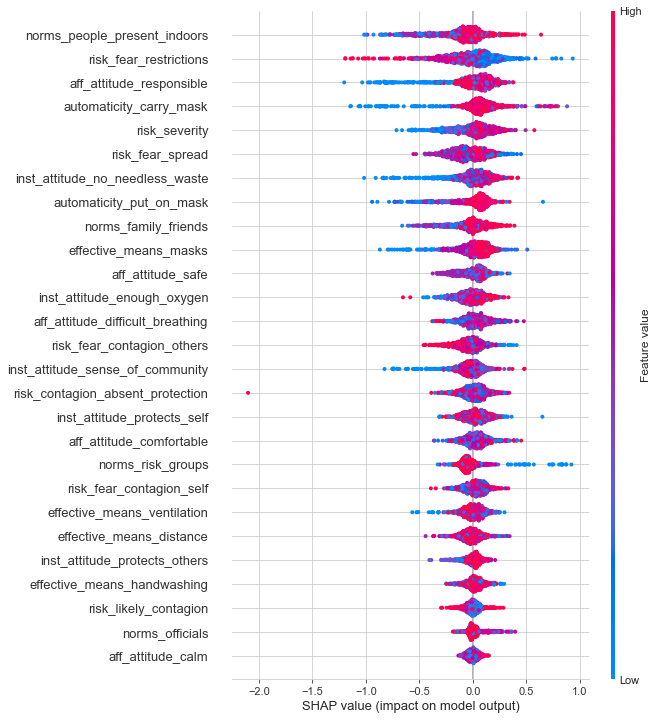

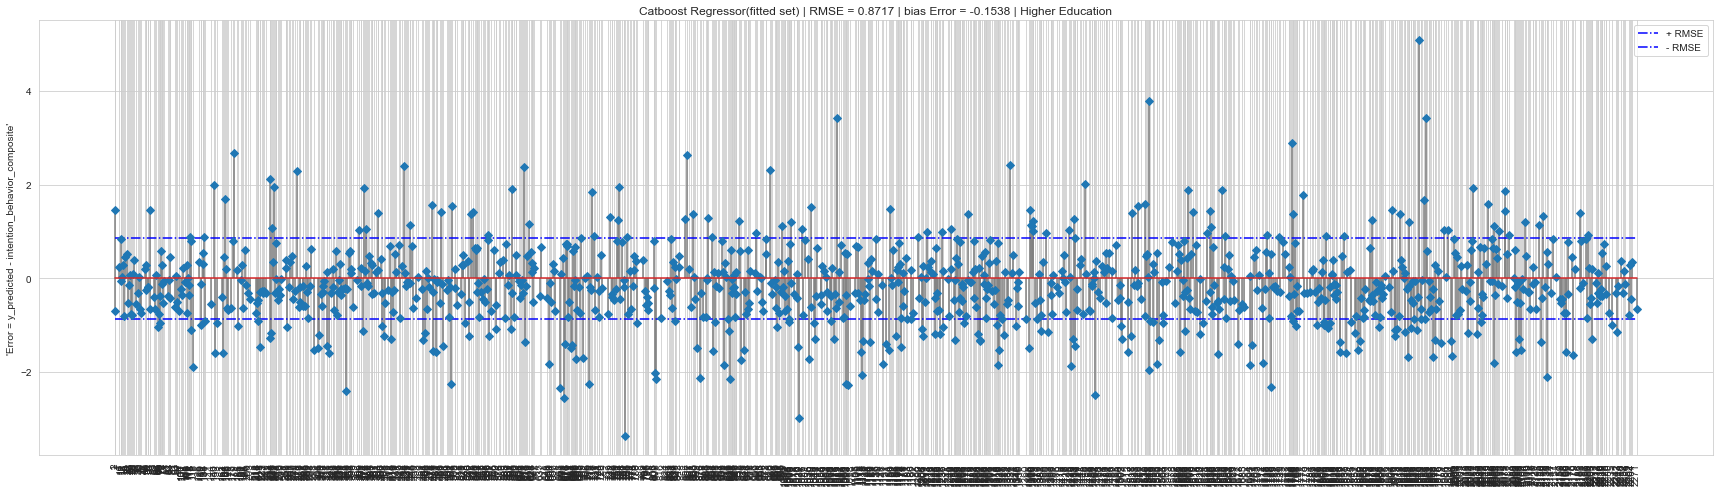

In [38]:
feature_plot_6, gini_plot_6, shap_plot_6, rmse_plot_6, feature_importance_df_6, shap_values_6 = naive_catboost_forest_summary(df = df[df["demographic_higher_education"]==1],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="Higher Education"
                                                                                  )

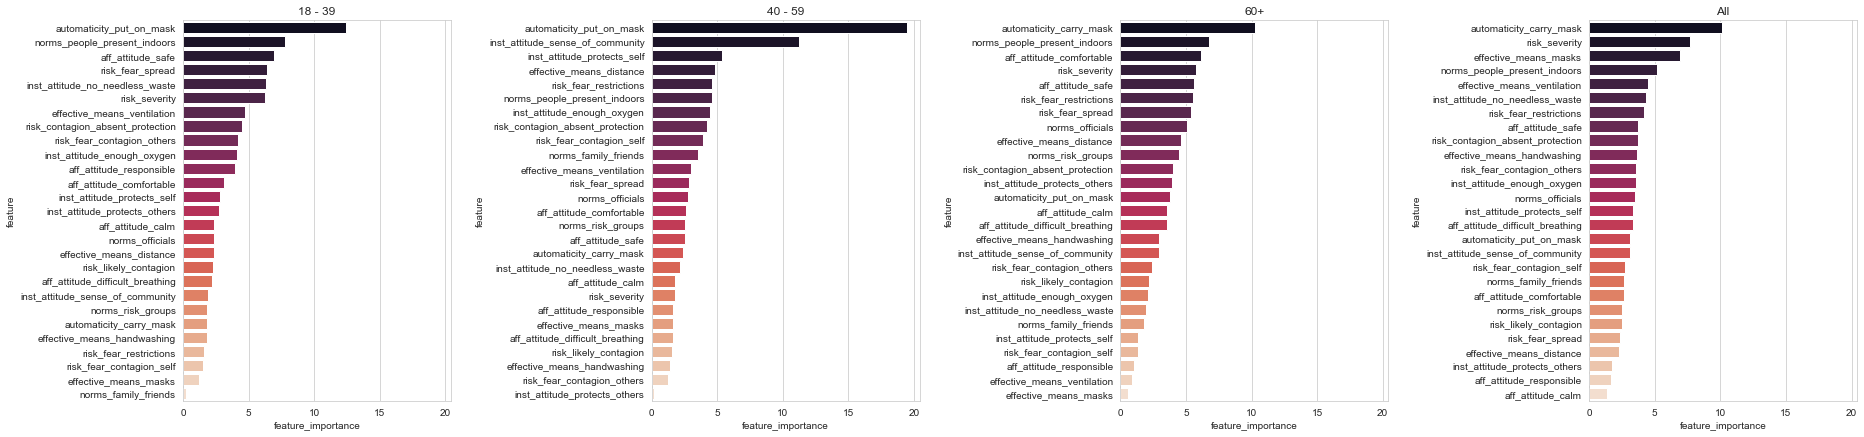

In [39]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 7),
                       gridspec_kw={'wspace': 0.75})
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(fi_dfs_list)):
    fi_df = fi_dfs_list[i]
    _ = sns.barplot(data=fi_df, 
                    x="feature_importance", 
                    y="feature",
                    ax=axs[i],
                    palette="rocket"
                    )
    _ = axs[i].set_title(fi_titles_list[i])
# _ = plt.show()

In [40]:
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]
for i in range(0, len(fi_dfs_list)):
    fi_dfs_list[i]["age_group"] = fi_titles_list[i]

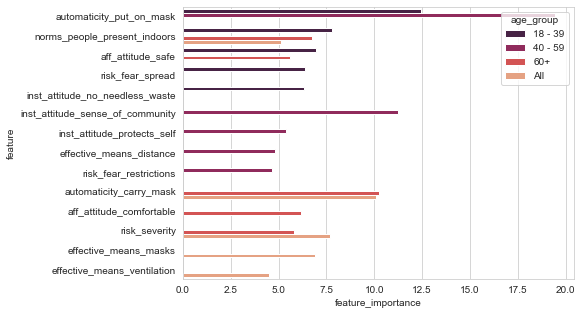

In [41]:
_ = plt.figure(figsize=(7, 5))
_ = sns.barplot(
                data=pd.concat(fi_dfs_list, axis=0).groupby("age_group").head(5),
                x="feature_importance", 
                y="feature",
                hue="age_group",
                palette="rocket",
                dodge=True
                )

In [42]:
fis_df = pd.concat(fi_dfs_list, axis=1)

In [43]:
fis_df.head(5)

feature  feature_importance age_group  \
0         automaticity_put_on_mask               12.42   18 - 39   
1     norms_people_present_indoors                7.77   18 - 39   
2                aff_attitude_safe                6.97   18 - 39   
3                 risk_fear_spread                6.38   18 - 39   
4  inst_attitude_no_needless_waste                6.32   18 - 39   

                            feature  feature_importance age_group  \
0          automaticity_put_on_mask               19.44   40 - 59   
1  inst_attitude_sense_of_community               11.25   40 - 59   
2       inst_attitude_protects_self                5.38   40 - 59   
3          effective_means_distance                4.80   40 - 59   
4            risk_fear_restrictions                4.63   40 - 59   

                        feature  feature_importance age_group  \
0       automaticity_carry_mask               10.24       60+   
1  norms_people_present_indoors                6.76       60+   
2      aff_attitude_comfortable                6.18       60+   
3                 risk_severity                5.80       60+   
4             aff_attitude_safe                5.61       60+   

                        feature  feature_importance age_group  
0       automaticity_carry_mask               10.10       All  
1                 risk_severity                7.71       All  
2         effective_means_masks                6.89       All  
3  norms_people_present_indoors                5.15       All  
4   effective_means_ventilation                4.49       All

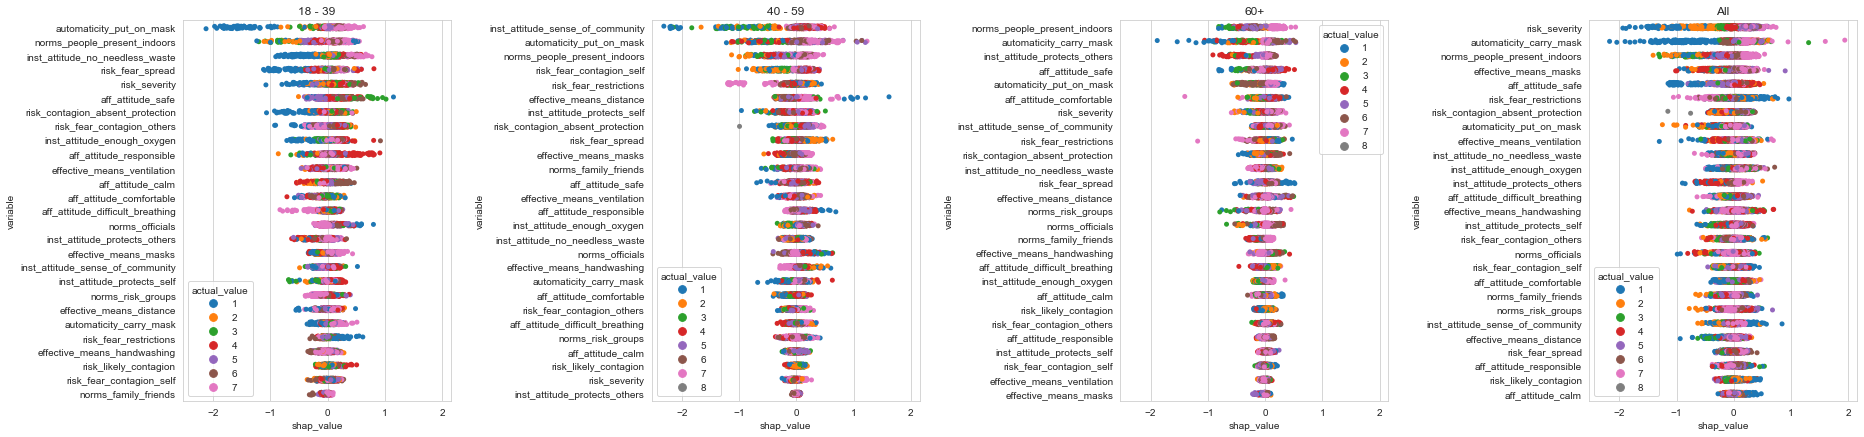

In [44]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 7),
                       gridspec_kw={'wspace': 0.75})
shap_dfs_list = [shap_values_0, shap_values_1, shap_values_2, shap_values_3]
shap_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(shap_dfs_list)):
    shap_df = shap_dfs_list[i]
    var_order = shap_df.groupby("variable").var().sort_values(by = "shap_value", ascending = False).index.tolist()
    _ = sns.stripplot(data=shap_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
                  order=var_order,
                    ax=axs[i],
                    )
    _ = axs[i].set_title(shap_titles_list[i])

In [45]:
tmp_df = df.reset_index(drop=True)

X = tmp_df[features_list[2:]]
y = tmp_df[grouping_var]

In [46]:
accuracies_list = list()
all_pred_test_df = pd.DataFrame()
all_cors_df = pd.DataFrame()
kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
fold_number = 1

model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    
    _ = model.fit(X = train_X, 
                y = train_y,
               cat_features=X.columns.tolist())
    
    pred_y = model.predict(test_X)
    _ = accuracies_list.append(np.sqrt(mean_squared_error(test_y, pred_y)))
    
    pred_test_df = pd.DataFrame({grouping_var: test_y,
                 "predict": pred_y,
                                "fold_number": f"fold_{fold_number}"})
    
    all_pred_test_df = pd.concat([all_pred_test_df, 
                             pred_test_df
                            ])

    corr_df = pg.corr(x=pred_test_df[grouping_var], 
            y=pred_test_df["predict"], 
            alternative='two-sided', 
            method='spearman', 
           )
    
    all_cors_df = pd.concat([all_cors_df, 
                             corr_df.assign(fold_number=f"fold_{fold_number}")
                            ])
    
    fold_number += 1

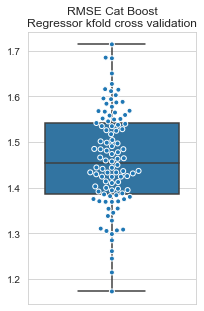

In [47]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("RMSE Cat Boost\nRegressor kfold cross validation")

In [48]:
pd.DataFrame(accuracies_list).describe().T

count      mean       std       min       25%      50%       75%       max
0  100.0  1.460889  0.107116  1.172973  1.387053  1.45378  1.542548  1.713833

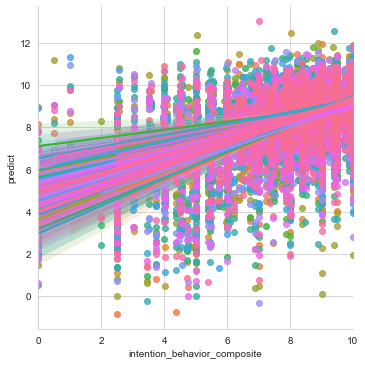

In [49]:
_ = sns.lmplot(data=all_pred_test_df, 
               x=grouping_var, 
               y="predict", 
               hue="fold_number",
              legend=False)

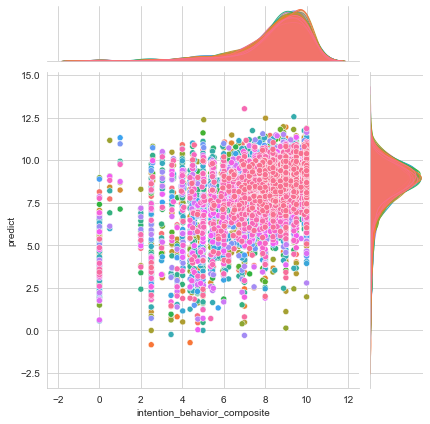

In [50]:
ax = sns.jointplot(data=all_pred_test_df, 
                  x=grouping_var, 
                  y="predict", 
                  hue="fold_number",
#                   kind="reg",
                   legend=False
                 )
# _ = ax._legend.remove()

In [51]:
all_cors_df.describe()

n           r         p-val       power
count  100.000000  100.000000  1.000000e+02  100.000000
mean   227.200000    0.337624  1.474281e-04    0.989853
std      0.402015    0.063481  8.058543e-04    0.031872
min    227.000000    0.177255  1.944096e-15    0.766244
25%    227.000000    0.293919  4.683890e-09    0.995085
50%    227.000000    0.338370  1.743040e-07    0.999554
75%    227.000000    0.376328  6.681203e-06    0.999965
max    228.000000    0.495058  7.426213e-03    1.000000

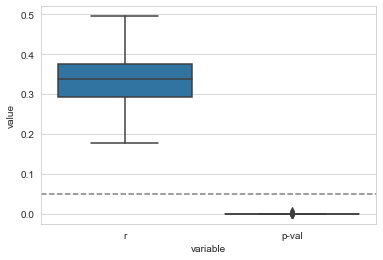

In [52]:
_ = sns.boxplot(data=all_cors_df[["r", "p-val"]].melt(),
                x="variable", y="value")
_ = plt.axhline(y=0.05, c="grey", ls="--")

In [53]:
sort_shap_list = (pd.merge(shap_values_3
         .assign(shap_value=lambda d: d[["shap_value"]].abs())
         .groupby("variable")
         .mean()
         .sort_values(by="shap_value", ascending=False), 
         meta_df.loc[meta_df["New variable name"].isin(features_list), ["Item english translation", "New variable name"]],
         left_index=True,
         right_on="New variable name")
 .set_index(["New variable name", "Item english translation"])
 .index
 .tolist()
#  .drop("New variable name", axis=1)
)

In [54]:
pd.Series([x[1] for x in sort_shap_list])

0              If you got a coronavirus infection, how serious a threat would you rate it to your health?
1                                       In the indoors spaces I visit, people on the site think I should…
2     Taking a mask with you to a store or public transport, for example, has already become automatic...
3                                                                                       Using a face mask
4                                                        When I use a face mask, I feel or would feel ...
5                              Consequences of measures taken to prevent the spread of the coronavirus...
6     How likely do you think you would get a coronavirus infection in your free time in the next mont...
7     What consequences do you think it has if you use a face mask in your free time? If or when I use...
8     What consequences do you think it has if you use a face mask in your free time? If or when I use...
9                                             

In [55]:
def naive_catboost_shap(df: pd.DataFrame,
                                 grouping_var: str,
                                 column_list: list,
                                  plot_title: str,
                        max_display: int
                                 ):
    y = df[grouping_var]
    X = df[column_list]

    model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

    # train the model
    _ = model.fit(X, y, cat_features=column_list)

    shap_values = model.get_feature_importance(Pool(X, label=y,cat_features=X.columns.tolist()), type="ShapValues")

    shap_values = shap_values[:,:-1]

    _ = shap.summary_plot(shap_values, 
                                  X.astype(int), 
                                  feature_names=X.columns, 
                                  max_display=max_display,
                                 show=False,
                         title=plot_title) 
    shap_plot = plt.gca()
    return shap_plot.get_figure()

In [56]:
display_length = 10

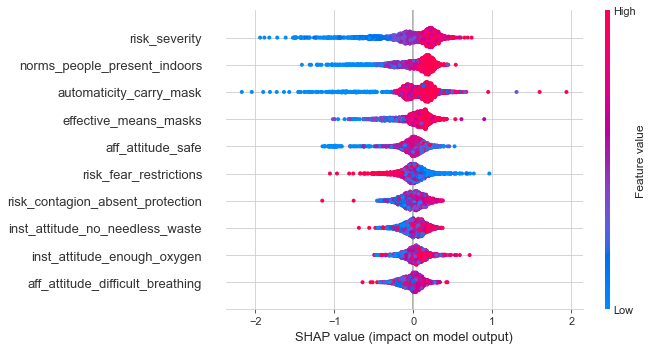

In [57]:
short_shap_plot_all = naive_catboost_shap(df = df,
                    grouping_var = grouping_var,
                    column_list = features_list,
                    plot_title="All",
                   max_display=display_length)

In [58]:
_ = short_shap_plot_all.gca().set_yticklabels(pd.Series([x[1] for x in sort_shap_list[:display_length]]).str.wrap(61).tolist(), fontsize=11)

In [59]:
short_shap_plot_all.set_figheight(8.5)
short_shap_plot_all.set_figwidth(12)

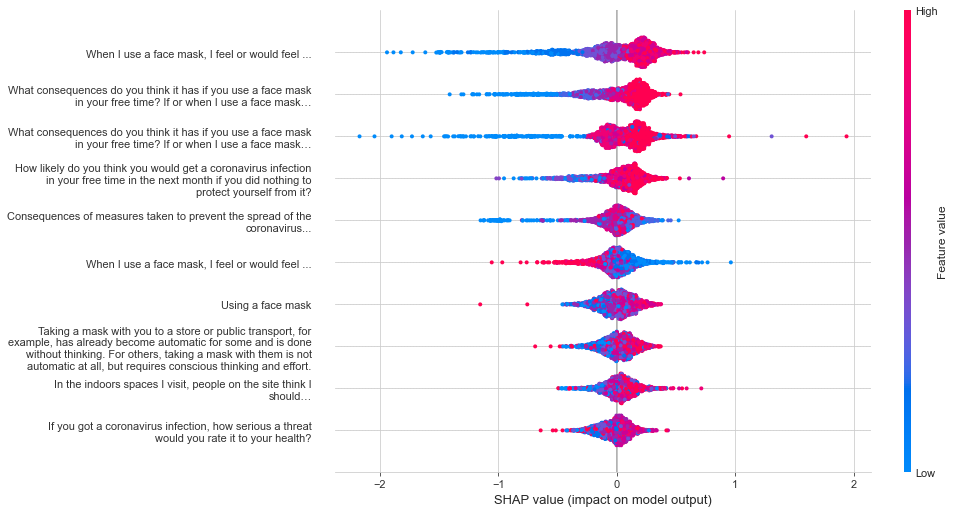

In [60]:
short_shap_plot_all

In [61]:
display_length = df.shape[0]

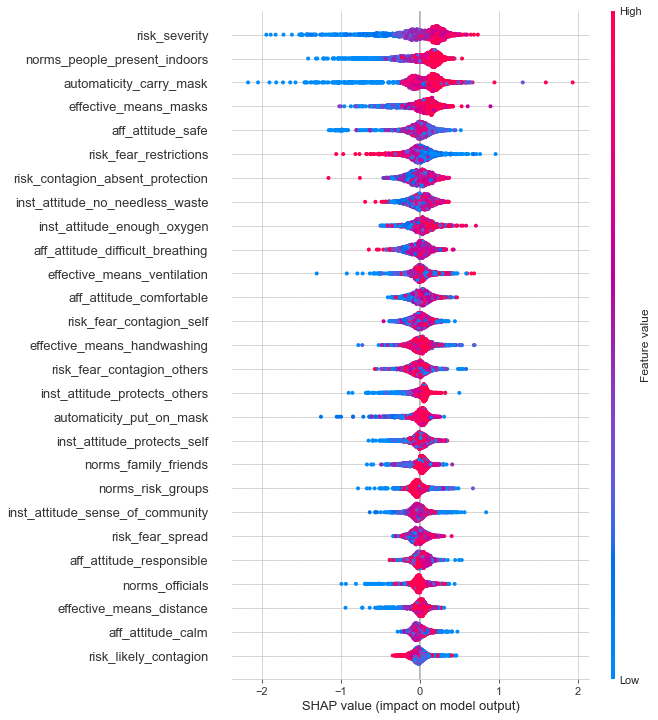

In [62]:
short_shap_plot_all = naive_catboost_shap(df = df,
                    grouping_var = grouping_var,
                    column_list = features_list,
                    plot_title="All",
                   max_display=display_length)

In [63]:
_ = short_shap_plot_all.gca().set_yticklabels(pd.Series([x[1] for x in sort_shap_list[:display_length]]).str.wrap(61).tolist(), fontsize=11)

In [70]:
short_shap_plot_all.set_figheight(30)
short_shap_plot_all.set_figwidth(12)

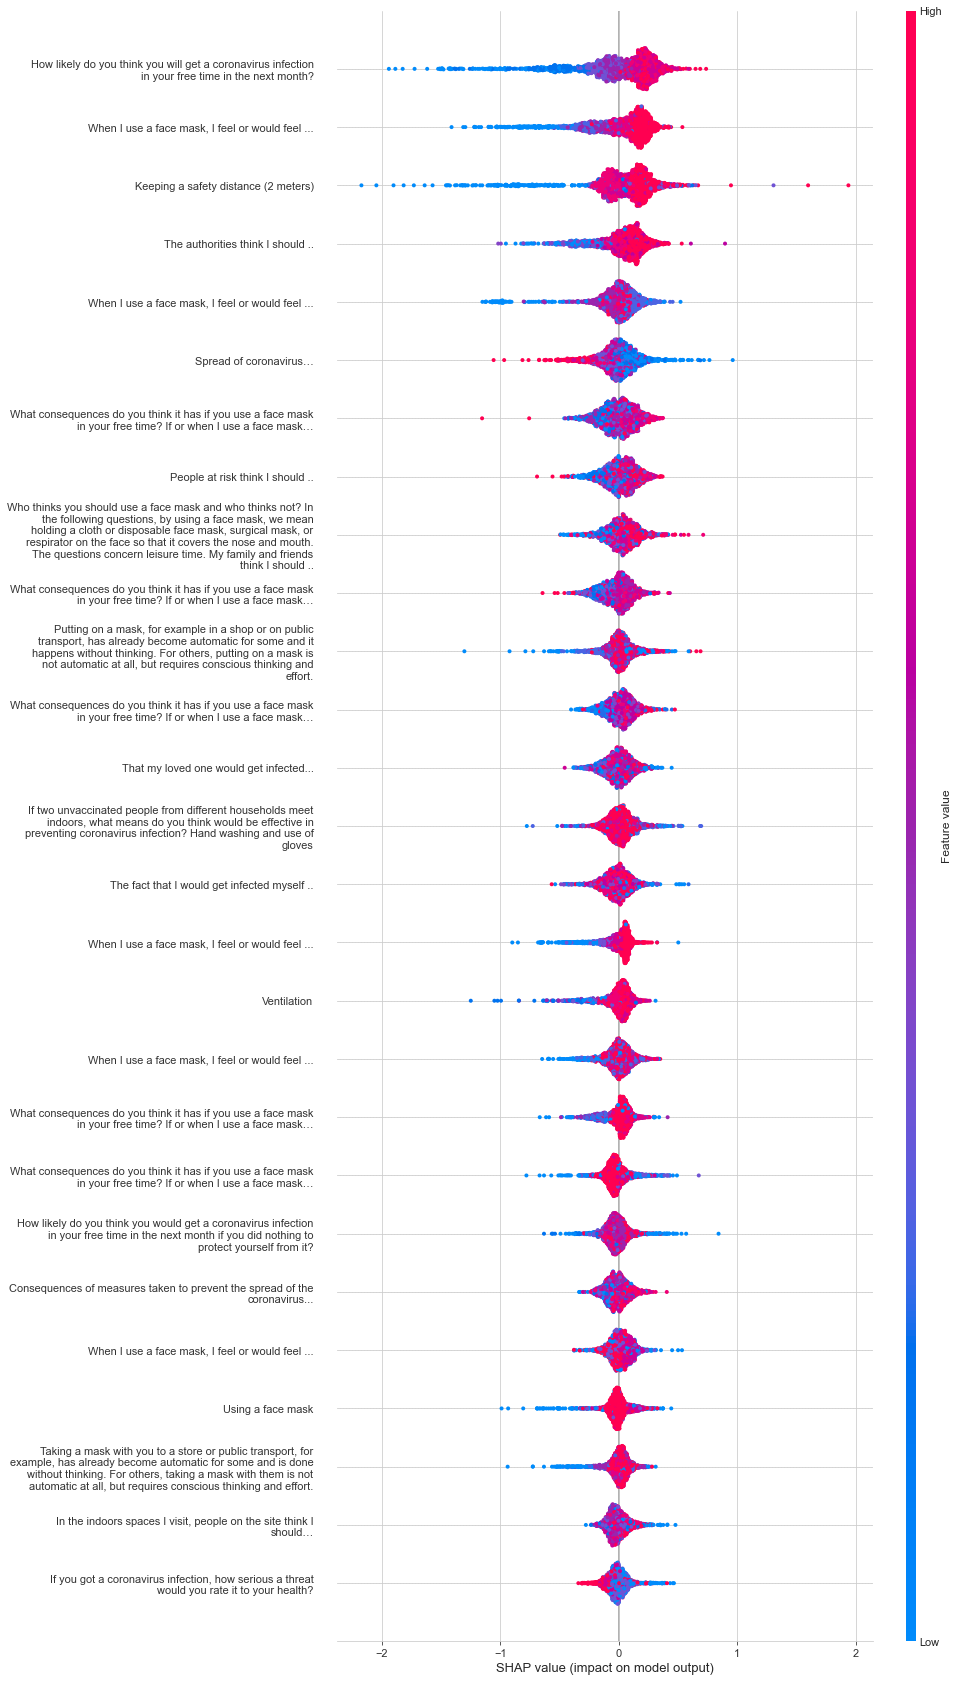

In [71]:
short_shap_plot_all